In [1]:
!pip install pyspark

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Build SparkSession

In [3]:
ps = SparkSession.builder.getOrCreate()

# Load Dataset

In [4]:
df = ps.read.csv("/content/drive/MyDrive/CV/Pyspark/Credit data.csv", header=True, inferSchema=True)

In [5]:
df.show()

+---+-------+---+----------+-------+---------------+-------------+--------------------+-------------------+--------------+-----------------+-------------------+---------+
| Id| income|age|experience|married|house_ownership|car_ownership|          profession|               city|         state|current_job_years|current_house_years|risk_flag|
+---+-------+---+----------+-------+---------------+-------------+--------------------+-------------------+--------------+-----------------+-------------------+---------+
|  1|1303835| 23|         3| single|         rented|           no| Mechanical_engineer|               Rewa|Madhya_Pradesh|                3|                 13|        0|
|  2|7574516| 40|        10| single|         rented|           no|  Software_Developer|           Parbhani|   Maharashtra|                9|                 13|        0|
|  3|3991815| 66|         4|married|         rented|           no|    Technical_writer|          Alappuzha|        Kerala|                4|     

# Data Exploration

In [6]:
df.describe().show()

+-------+-----------------+-----------------+-----------------+------------------+-------+---------------+-------------+--------------------+-----------+--------------+-----------------+-------------------+-------------------+
|summary|               Id|           income|              age|        experience|married|house_ownership|car_ownership|          profession|       city|         state|current_job_years|current_house_years|          risk_flag|
+-------+-----------------+-----------------+-----------------+------------------+-------+---------------+-------------+--------------------+-----------+--------------+-----------------+-------------------+-------------------+
|  count|           252000|           252000|           252000|            252000| 252000|         252000|       252000|              252000|     252000|        252000|           252000|             252000|             252000|
|   mean|         126000.5|4997116.665333333|49.95407142857143|10.084436507936507|   null|  

In [7]:
for column_name in df.columns:
  count_null = df.filter(col(column_name).isNull()).count()
  if count_null:
    print("Column name '{column_name}' have {count_null} null value")

In [8]:
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- income: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- experience: integer (nullable = true)
 |-- married: string (nullable = true)
 |-- house_ownership: string (nullable = true)
 |-- car_ownership: string (nullable = true)
 |-- profession: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- current_job_years: integer (nullable = true)
 |-- current_house_years: integer (nullable = true)
 |-- risk_flag: integer (nullable = true)



In [9]:
print((df.count(), len(df.columns)))

(252000, 13)


In [10]:
print(f"Số lượng mẫu trùng lặp {df.count() - df.dropDuplicates().count()}")

Số lượng mẫu trùng lặp 0


In [11]:
def feature_visualize(df, feature_name, xlabel, ylabel, title, rotation=None):
  plt.figure(figsize=(20,8))
  df_temp = df.groupBy(feature_name, "risk_flag").count().sort(feature_name).toPandas()

  y_0 = df_temp[df_temp["risk_flag"]==0]["count"]
  y_1 = df_temp[df_temp["risk_flag"]==1]["count"]

  x_axis = df_temp[feature_name].unique()

  plt.bar(np.arange(len(x_axis)) -0.2, y_0, width=0.4, label = '0')
  plt.bar(np.arange(len(x_axis)) +0.2, y_1, width=0.4, label = '1')

  plt.xticks(np.arange(len(x_axis)), labels=x_axis, rotation=rotation)

  plt.legend()
  plt.xlabel(xlabel, fontsize=25)
  plt.ylabel(ylabel, fontsize=25)
  plt.title(title, fontsize=25)
  plt.show()

# Visualize the Features

<Axes: xlabel='risk_flag', ylabel='income'>

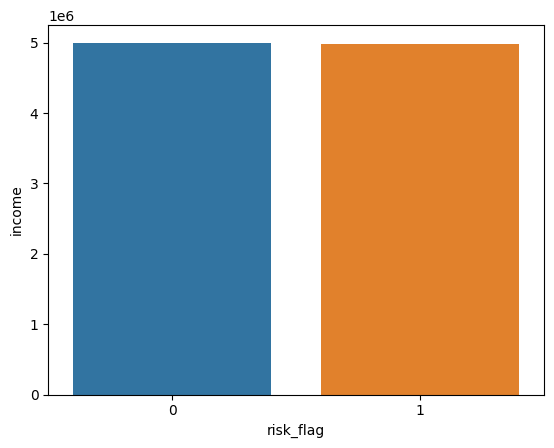

In [12]:
sns.barplot(data=df.select("risk_flag", "income").toPandas().groupby("risk_flag").mean().reset_index(), x="risk_flag", y="income")

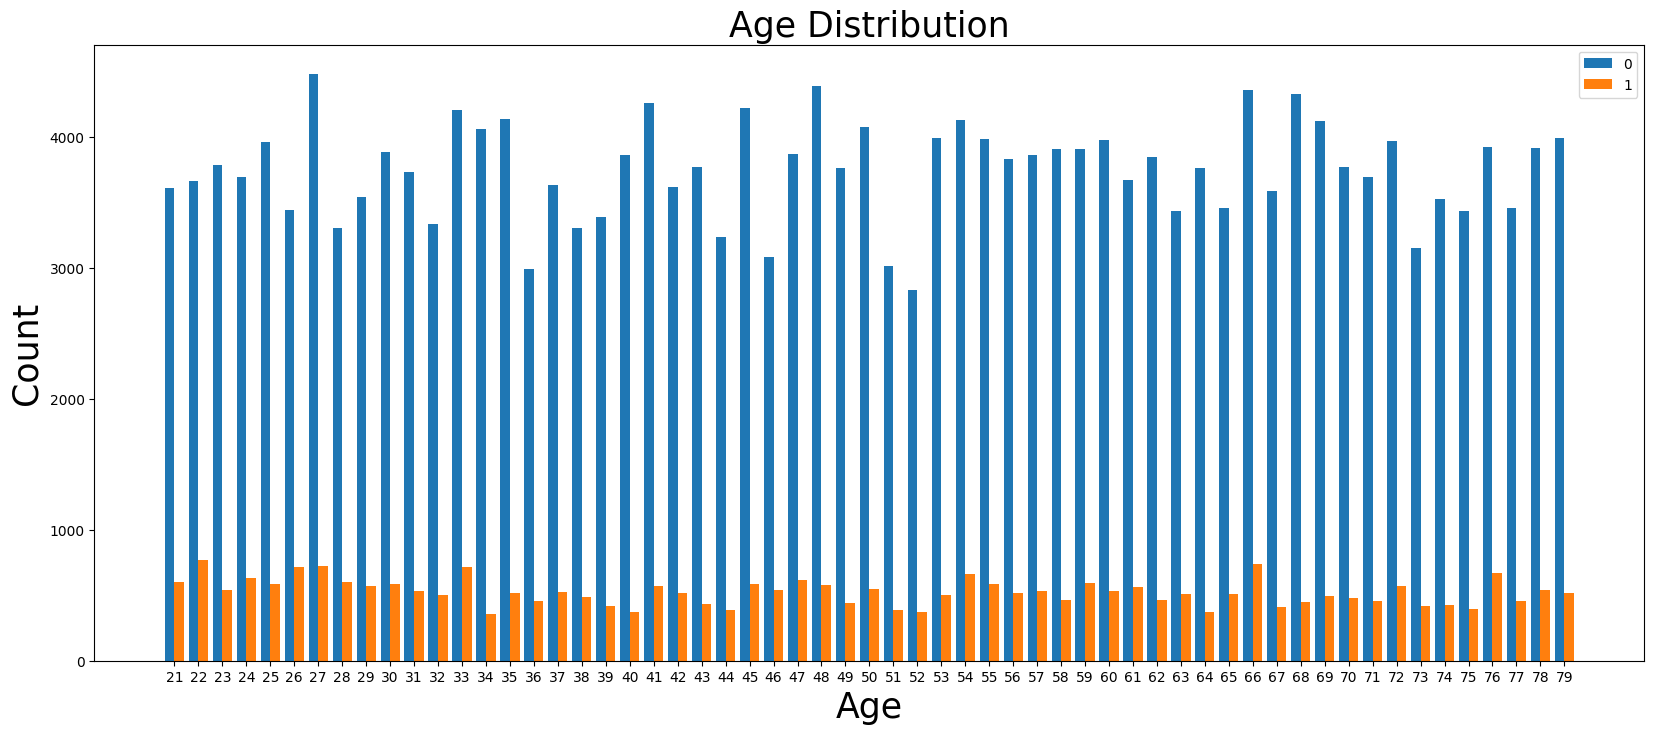

In [13]:
feature_visualize(df, "age", "Age", "Count", "Age Distribution")

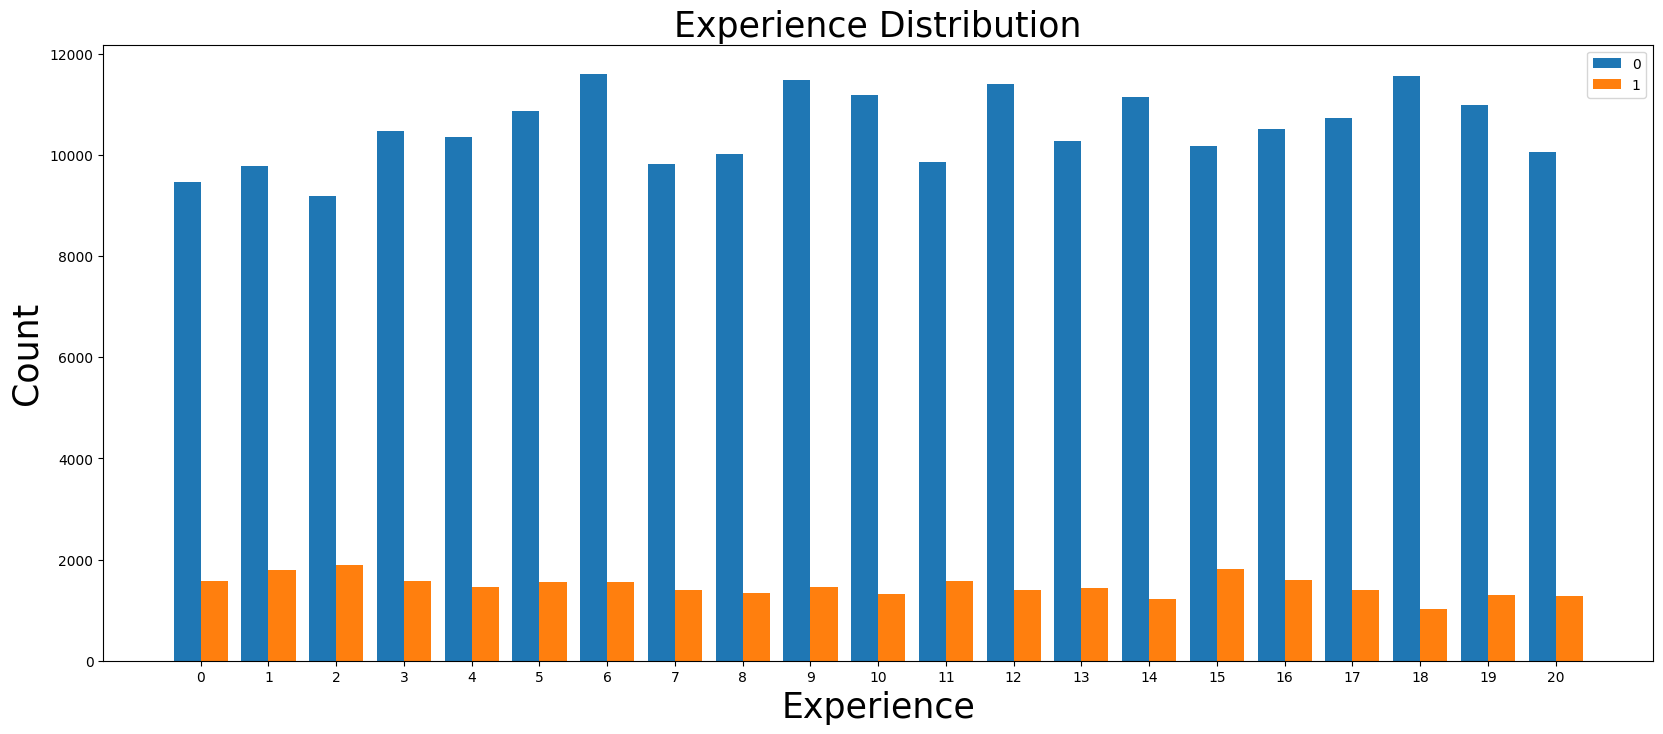

In [14]:
feature_visualize(df, "experience", "Experience", "Count", "Experience Distribution")

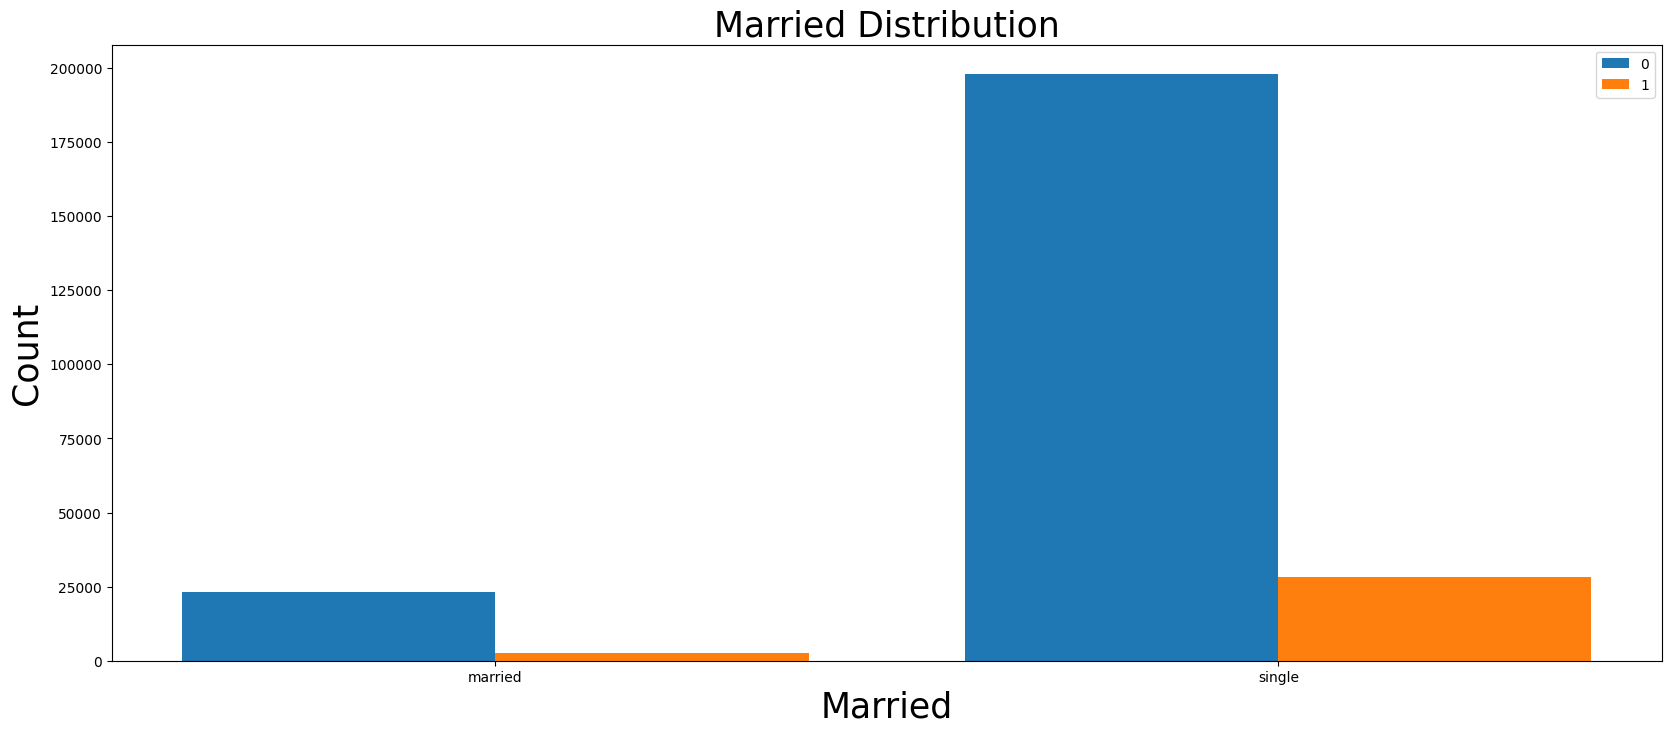

In [15]:
feature_visualize(df, "married", "Married", "Count", "Married Distribution")

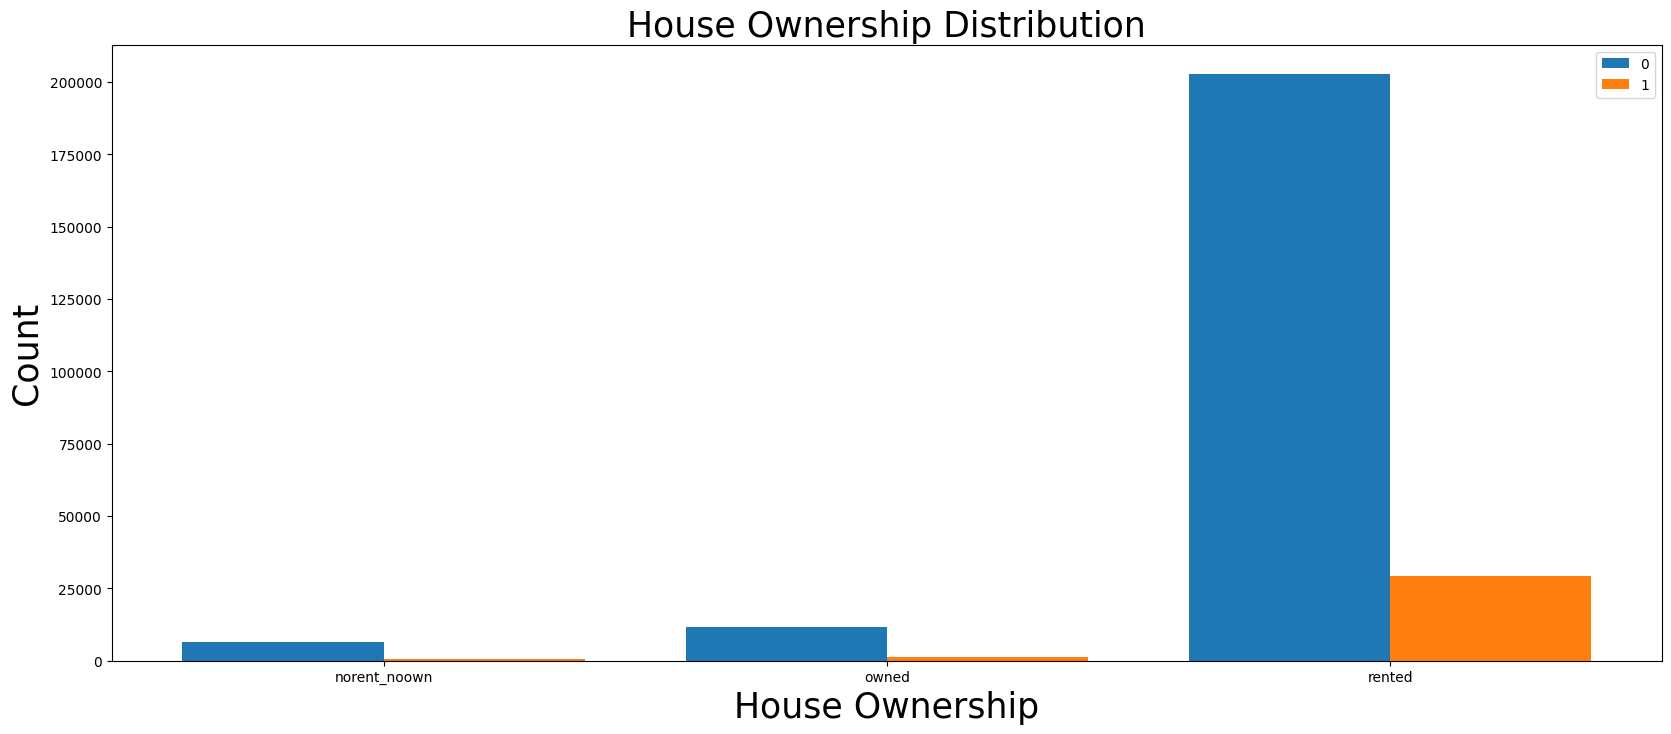

In [16]:
feature_visualize(df, "house_ownership", "House Ownership", "Count", "House Ownership Distribution")

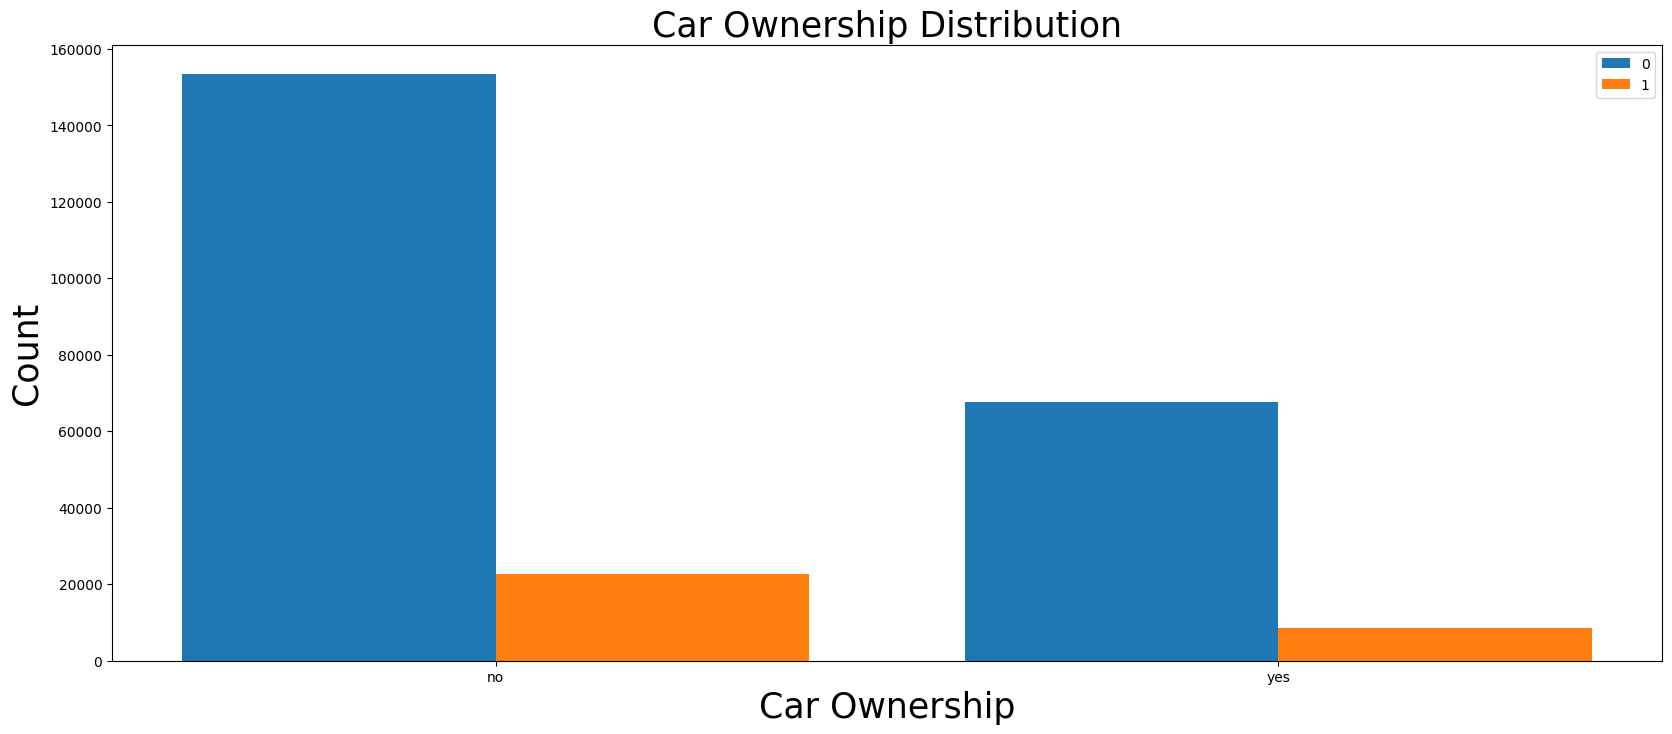

In [17]:
feature_visualize(df, "car_ownership", "Car Ownership", "Count", "Car Ownership Distribution")

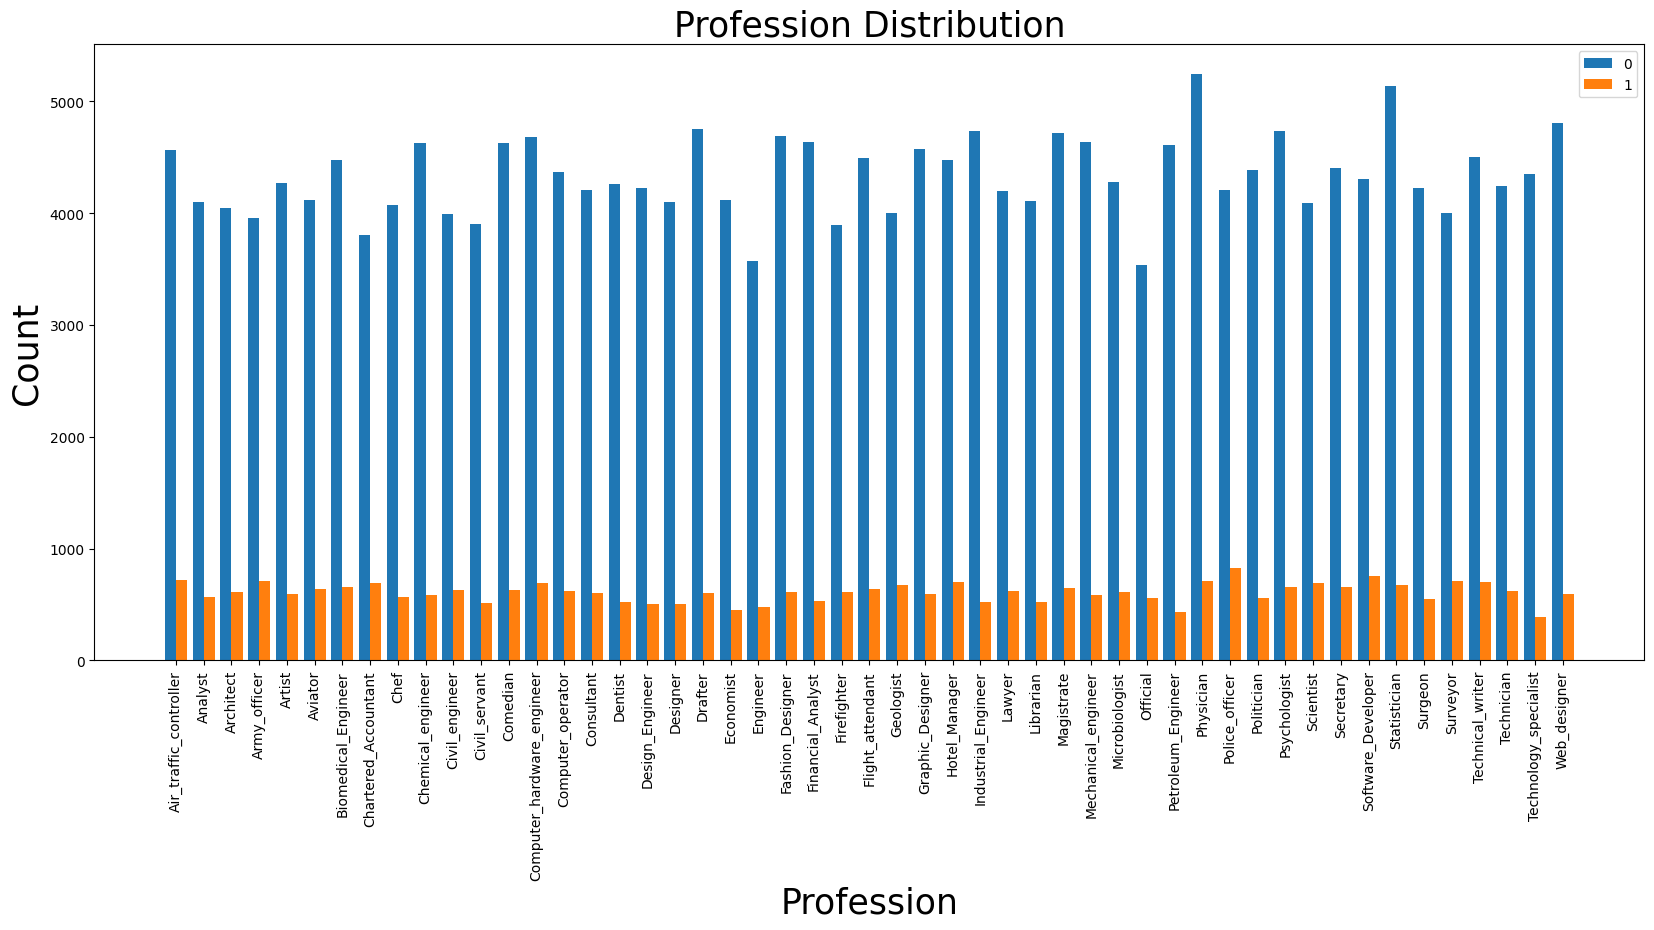

In [18]:
feature_visualize(df, "profession", "Profession", "Count", "Profession Distribution", rotation=90)

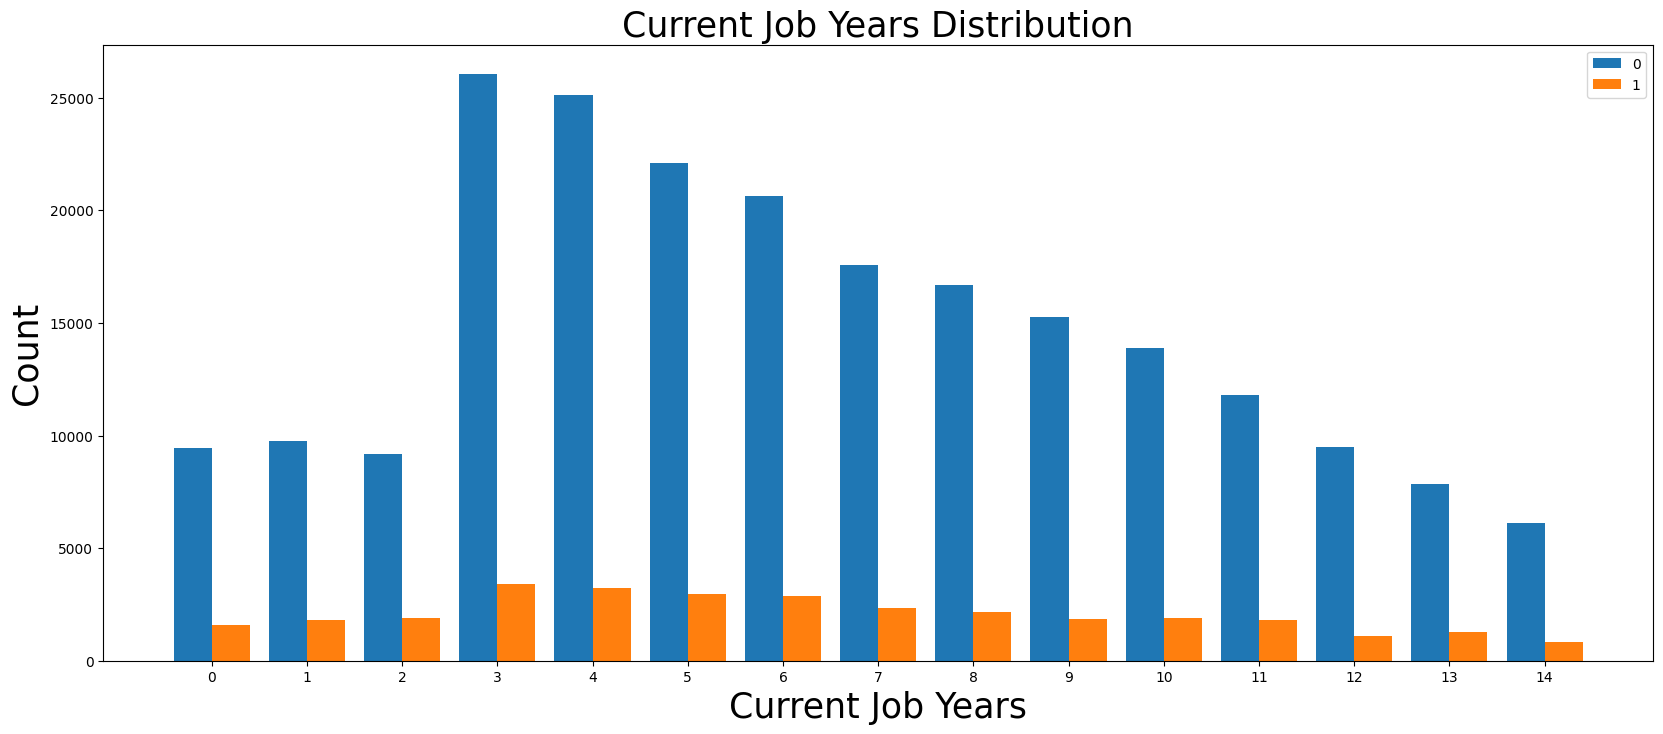

In [19]:
feature_visualize(df, "current_job_years", "Current Job Years", "Count", "Current Job Years Distribution")

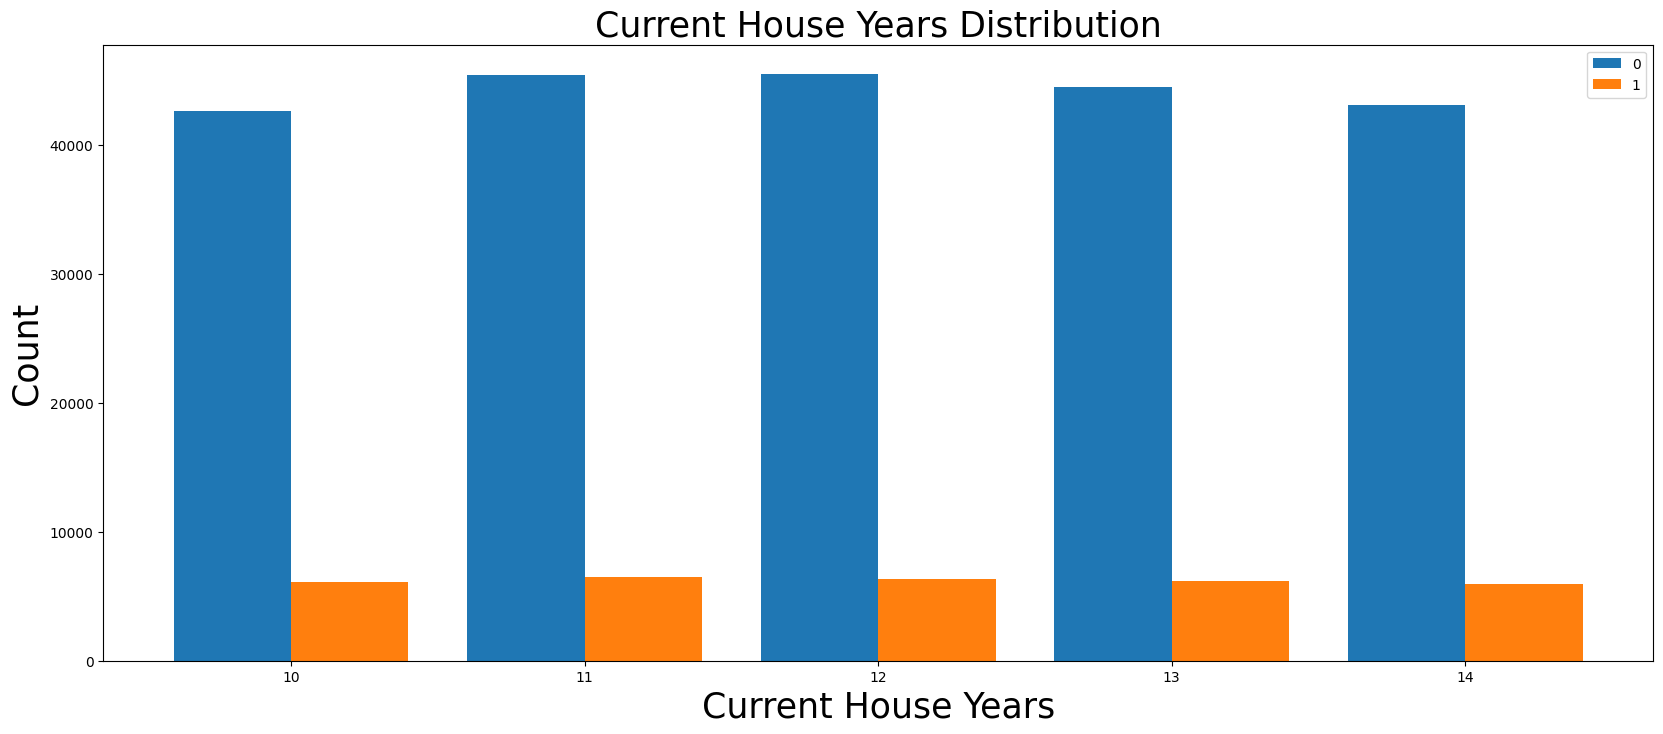

In [20]:
feature_visualize(df, "current_house_years", "Current House Years", "Count", "Current House Years Distribution")

Text(0.5, 1.0, 'Distribution of Risk Flag')

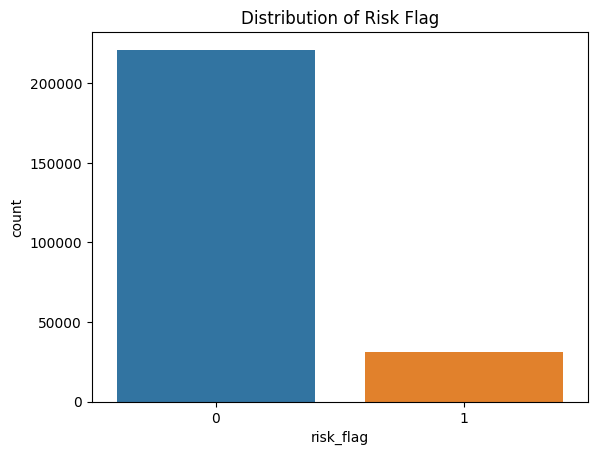

In [21]:
sns.countplot(x = df.select("risk_flag").toPandas()["risk_flag"])
plt.title("Distribution of Risk Flag")

In [22]:
df.show()

+---+-------+---+----------+-------+---------------+-------------+--------------------+-------------------+--------------+-----------------+-------------------+---------+
| Id| income|age|experience|married|house_ownership|car_ownership|          profession|               city|         state|current_job_years|current_house_years|risk_flag|
+---+-------+---+----------+-------+---------------+-------------+--------------------+-------------------+--------------+-----------------+-------------------+---------+
|  1|1303835| 23|         3| single|         rented|           no| Mechanical_engineer|               Rewa|Madhya_Pradesh|                3|                 13|        0|
|  2|7574516| 40|        10| single|         rented|           no|  Software_Developer|           Parbhani|   Maharashtra|                9|                 13|        0|
|  3|3991815| 66|         4|married|         rented|           no|    Technical_writer|          Alappuzha|        Kerala|                4|     

# Encode For Categorical Feature

In [23]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

inputcols = ["married","house_ownership","car_ownership","profession","city","state"]
outputcols = [feature_name + "_index" for feature_name in inputcols]
indexers = StringIndexer(inputCols=inputcols, outputCols=outputcols)

df_encode = indexers.fit(df).transform(df)
onehot_encoder = OneHotEncoder(inputCols=["house_ownership_index", "profession_index", "city_index", "state_index"],
                               outputCols=["house_ownership_encode", "profession_encode", "city_encode", "state_encode"])
df_encode = onehot_encoder.fit(df_encode).transform(df_encode) # A sparse vector

In [24]:
input_feature = ["income", "age", "experience", "married_index", "house_ownership_encode", "car_ownership_index",
                 "profession_encode", "city_encode", "current_job_years", "current_house_years"]
df_encode.select(input_feature).show()

+-------+---+----------+-------------+----------------------+-------------------+-----------------+-----------------+-----------------+-------------------+
| income|age|experience|married_index|house_ownership_encode|car_ownership_index|profession_encode|      city_encode|current_job_years|current_house_years|
+-------+---+----------+-------------+----------------------+-------------------+-----------------+-----------------+-----------------+-------------------+
|1303835| 23|         3|          0.0|         (2,[0],[1.0])|                0.0|  (50,[11],[1.0])|(316,[151],[1.0])|                3|                 13|
|7574516| 40|        10|          0.0|         (2,[0],[1.0])|                0.0|  (50,[20],[1.0])|(316,[119],[1.0])|                9|                 13|
|3991815| 66|         4|          1.0|         (2,[0],[1.0])|                0.0|  (50,[13],[1.0])|(316,[228],[1.0])|                4|                 10|
|6256451| 41|         2|          0.0|         (2,[0],[1.0])|   

# Feature Vectors

In [25]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols=input_feature, outputCol="feature")
data = assembler.transform(df_encode).select("feature", "risk_flag")

In [26]:
data.show()

+--------------------+---------+
|             feature|risk_flag|
+--------------------+---------+
|(375,[0,1,2,4,18,...|        0|
|(375,[0,1,2,4,27,...|        0|
|(375,[0,1,2,3,4,2...|        0|
|(375,[0,1,2,4,6,2...|        1|
|(375,[0,1,2,4,55,...|        1|
|(375,[0,1,4,55,17...|        0|
|(375,[0,1,2,3,4,4...|        0|
|(375,[0,1,2,4,52,...|        0|
|(375,[0,1,2,4,6,2...|        0|
|(375,[0,1,2,4,47,...|        0|
|(375,[0,1,2,4,24,...|        0|
|(375,[0,1,2,4,51,...|        0|
|(375,[0,1,2,4,7,7...|        0|
|(375,[0,1,2,4,22,...|        0|
|(375,[0,1,2,4,20,...|        1|
|(375,[0,1,2,3,4,6...|        0|
|(375,[0,1,2,3,4,1...|        0|
|(375,[0,1,2,4,31,...|        1|
|(375,[0,1,2,4,29,...|        0|
|(375,[0,1,2,4,34,...|        0|
+--------------------+---------+
only showing top 20 rows



# Standardize features

In [27]:
scale = StandardScaler(inputCol="feature", outputCol="feature_scaled")
data = scale.fit(data).transform(data)

# PCA (dimensionality reduction)

In [28]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA

pca = PCA(k=7, inputCol="feature_scaled", outputCol="feature_scaled_pca")
data = pca.fit(data).transform(data)

In [29]:
data.select("feature", "feature_scaled", "feature_scaled_pca", "risk_flag").show()

+--------------------+--------------------+--------------------+---------+
|             feature|      feature_scaled|  feature_scaled_pca|risk_flag|
+--------------------+--------------------+--------------------+---------+
|(375,[0,1,2,4,18,...|(375,[0,1,2,4,18,...|[-1.4403646069127...|        0|
|(375,[0,1,2,4,27,...|(375,[0,1,2,4,27,...|[-1.7728031664885...|        0|
|(375,[0,1,2,3,4,2...|(375,[0,1,2,3,4,2...|[-2.5924859322418...|        0|
|(375,[0,1,2,4,6,2...|(375,[0,1,2,4,6,2...|[-1.9025686632849...|        1|
|(375,[0,1,2,4,55,...|(375,[0,1,2,4,55,...|[-1.6103117973252...|        1|
|(375,[0,1,4,55,17...|(375,[0,1,4,55,17...|[-1.9773533567842...|        0|
|(375,[0,1,2,3,4,4...|(375,[0,1,2,3,4,4...|[-2.2400455700576...|        0|
|(375,[0,1,2,4,52,...|(375,[0,1,2,4,52,...|[-2.0523757991232...|        0|
|(375,[0,1,2,4,6,2...|(375,[0,1,2,4,6,2...|[-2.0181682220380...|        0|
|(375,[0,1,2,4,47,...|(375,[0,1,2,4,47,...|[-0.7594097676597...|        0|
|(375,[0,1,2,4,24,...|(37

In [30]:
data = data.select("feature_scaled_pca", "risk_flag")

In [31]:
data.select("feature_scaled_pca").collect()[:5]

[Row(feature_scaled_pca=DenseVector([-1.4404, 1.1798, -0.4206, 3.7793, 0.7341, -0.9122, -1.7541])),
 Row(feature_scaled_pca=DenseVector([-1.7728, 2.647, 1.2185, 3.2247, 0.4321, -0.9243, -0.7109])),
 Row(feature_scaled_pca=DenseVector([-2.5925, 1.925, -1.4602, 0.8563, 2.0895, -2.2222, -2.4072])),
 Row(feature_scaled_pca=DenseVector([-1.9026, 1.2226, 0.4082, 3.103, 2.6378, -0.4962, 0.0025])),
 Row(feature_scaled_pca=DenseVector([-1.6103, 2.5094, -1.4704, 2.8841, 2.5082, -0.3665, -2.1838]))]

# Undersampling

In [32]:
major_label = data.filter(col("risk_flag") == 0)
minor_label = data.filter(col("risk_flag") == 1)
ratio_of_imbalance = int(major_label.count()/minor_label.count())

# cut down the size of the majority class
undersampled_data = major_label.sample(False, 1/ratio_of_imbalance, seed=42)

# combine the cut down majority rows and the minority rows
balanced_data = undersampled_data.unionAll(minor_label)

In [33]:
print("Number of label_0: ",balanced_data.filter(col("risk_flag") == 0).count())
print("Number of label_1: ",balanced_data.filter(col("risk_flag") == 1).count())

Number of label_0:  31785
Number of label_1:  30996


In [34]:
# data shuffling
from pyspark.sql.functions import rand
balanced_data = balanced_data.withColumn("random", rand(seed=42)).orderBy("random").drop("random")

# Train_test Split

In [35]:
train, test = balanced_data.randomSplit([0.7, 0.3], seed=42)

In [36]:
train.count()

44134

In [37]:
test.count()

18661

# Logistic Regression

In [38]:
from pyspark.ml.classification import LogisticRegression

LR_model = LogisticRegression(featuresCol="feature_scaled_pca", labelCol="risk_flag")
LR_model = LR_model.fit(train)
pred_test = LR_model.transform(test)

In [39]:
pred_test.show()

+--------------------+---------+--------------------+--------------------+----------+
|  feature_scaled_pca|risk_flag|       rawPrediction|         probability|prediction|
+--------------------+---------+--------------------+--------------------+----------+
|[-2.8665893812963...|        1|[-0.1261790516969...|[0.46849702296570...|       1.0|
|[-2.8665893812963...|        1|[-0.1261790516969...|[0.46849702296570...|       1.0|
|[-2.8665893812963...|        1|[-0.1261790516969...|[0.46849702296570...|       1.0|
|[-2.8439303527405...|        0|[-0.0457220625883...|[0.48857147523448...|       1.0|
|[-2.8366849609651...|        0|[-0.1727241491913...|[0.45692599732066...|       1.0|
|[-2.8366849609651...|        0|[-0.1727241491913...|[0.45692599732066...|       1.0|
|[-2.8366849609651...|        0|[-0.1727241491913...|[0.45692599732066...|       1.0|
|[-2.7987772362283...|        1|[-0.1426268719884...|[0.46440360463649...|       1.0|
|[-2.7890221311171...|        0|[-0.1317941877465...|[

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
def PRF_metric(pred_test):
  df = pred_test.select("risk_flag", "prediction").toPandas()
  actual, pred = df["risk_flag"].values, df["prediction"].values
  print("Precision:", precision_score(actual, pred, average="macro"))
  print("Recall:", recall_score(actual, pred, average="macro"))
  print("F1-score:", f1_score(actual, pred, average="macro"))
  print("Detail:\n", classification_report(actual, pred))

In [41]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="risk_flag", metricName="areaUnderROC")
print("Logistics Regression Test Data AUC_ROC:", round(evaluator.evaluate(pred_test),2))
PRF_metric(pred_test)

Logistics Regression Test Data AUC_ROC: 0.54
Precision: 0.5256687915440776
Recall: 0.5249239856820217
F1-score: 0.5222230764071301
Detail:
               precision    recall  f1-score   support

           0       0.53      0.61      0.57      9506
           1       0.52      0.44      0.48      9147

    accuracy                           0.53     18653
   macro avg       0.53      0.52      0.52     18653
weighted avg       0.53      0.53      0.52     18653



# Decision Tree

In [42]:
from pyspark.ml.classification import DecisionTreeClassifier

DT_model = DecisionTreeClassifier(featuresCol="feature_scaled_pca", labelCol="risk_flag")
DT_model = DT_model.fit(train)
pred_test = DT_model.transform(test)

print("Decision Tree Test Data AUC:", round(evaluator.evaluate(pred_test),2))
PRF_metric(pred_test)

Decision Tree Test Data AUC: 0.51
Precision: 0.5446916475739332
Recall: 0.5440182756169298
F1-score: 0.5416714136813559
Detail:
               precision    recall  f1-score   support

           0       0.56      0.48      0.52      9485
           1       0.53      0.61      0.57      9180

    accuracy                           0.54     18665
   macro avg       0.54      0.54      0.54     18665
weighted avg       0.54      0.54      0.54     18665



# RandomForest

In [43]:
from pyspark.ml.classification import RandomForestClassifier

DT_model = RandomForestClassifier(featuresCol="feature_scaled_pca", labelCol="risk_flag")
DT_model = DT_model.fit(train)
pred_test = DT_model.transform(test)

print("Decision Tree Test Data AUC:", round(evaluator.evaluate(pred_test),2))
PRF_metric(pred_test)

Decision Tree Test Data AUC: 0.61
Precision: 0.56190539000321
Recall: 0.551237914501161
F1-score: 0.5322415182131126
Detail:
               precision    recall  f1-score   support

           0       0.54      0.76      0.63      9425
           1       0.58      0.34      0.43      9225

    accuracy                           0.55     18650
   macro avg       0.56      0.55      0.53     18650
weighted avg       0.56      0.55      0.53     18650



# SVC

In [44]:
from pyspark.ml.classification import LinearSVC # kernel: linear

SVM_model = LinearSVC(featuresCol ="feature_scaled_pca", labelCol ="risk_flag")
SVM_model = SVM_model.fit(train)
pred_test = SVM_model.transform(test)

print("SVM Test Data AUC:", round(evaluator.evaluate(pred_test),2))
PRF_metric(pred_test)

SVM Test Data AUC: 0.54
Precision: 0.5206837716942606
Recall: 0.520559401576824
F1-score: 0.5199995760829698
Detail:
               precision    recall  f1-score   support

           0       0.52      0.56      0.54      9410
           1       0.52      0.48      0.50      9242

    accuracy                           0.52     18652
   macro avg       0.52      0.52      0.52     18652
weighted avg       0.52      0.52      0.52     18652



# XG_Boost

In [45]:
from xgboost.spark import SparkXGBClassifier

XGB_model = SparkXGBClassifier(features_col ="feature_scaled_pca", label_col ="risk_flag")
XGB_model = XGB_model.fit(train)
pred_test = XGB_model.transform(test)

print("XGB Test Data AUC:", round(evaluator.evaluate(pred_test),2))
PRF_metric(pred_test)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


XGB Test Data AUC: 0.92
Precision: 0.8646199309914145
Recall: 0.8646647821990288
F1-score: 0.8646351040396747
Detail:
               precision    recall  f1-score   support

           0       0.87      0.86      0.87      9450
           1       0.86      0.87      0.86      9198

    accuracy                           0.86     18648
   macro avg       0.86      0.86      0.86     18648
weighted avg       0.86      0.86      0.86     18648

